In [1]:
import datetime

import pandas as pd
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (8,6)
import seaborn as sns
import numpy as np

In [2]:
import lightgbm as lgb
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy import stats

In [3]:
from google.colab import drive
drive.mount('/content/drive')

GOOGLE_MY_DRIVE = "/content/drive/MyDrive/JAPEX/code/input/"
INPUT_DIR = GOOGLE_MY_DRIVE

In [4]:
def correlation_plot(data, lags=60):
    fig = plt.figure(figsize=(10, 8))
    # 自己相関のコレログラム
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_ylim(-1.1, 1.1)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    # 偏自己相関のコレログラム
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_ylim(-1.1, 1.1)    
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()

In [5]:
def plot_feature_importance(df, title=None):
    plt.figure(figsize=(10,10))
    n_features = len(df) # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance') # df_importanceをプロット用に特徴量重要度を昇順ソート 
    plt.barh(range(n_features), df_plot['importance'].values) 
    cols_plot = df_plot['feature'].values # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot) # x軸,y軸の値の設定
    plt.xlabel('Feature importance', fontsize=14)                  # x軸のタイトル
    plt.ylabel('Feature', fontsize=14)
    plt.tick_params(labelsize=14)
    if title != None:
        plt.title(f"{title}", fontsize=14)
    plt.show()

In [6]:
data = pd.read_csv(INPUT_DIR + "daily_production.csv")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

In [7]:
data.head()

,gasvol,choke,hrsonline,whp,wht,hrsoffline,year,week,dayofweek
date,,,,,,,,,
2005-01-11,1790574.461,35.8,24.0,163.0,53.5,0.0,2005,2,1
2005-01-12,2610154.532,97.4,24.0,72.3,43.3,0.0,2005,2,2
2005-01-13,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,3
2005-01-14,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,4
2005-01-15,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,5


In [8]:
data.describe()

,gasvol,choke,hrsonline,whp,wht,hrsoffline,year,week,dayofweek
count,5.080000e+03,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000,5080.000000
mean,4.517001e+05,64.505906,18.132953,28.051555,32.831752,5.867047,2011.483465,26.507283,3.000000
std,5.511638e+05,44.109146,9.554588,21.576947,15.090307,9.554588,4.009995,14.978016,1.999705
min,0.000000e+00,0.000000,0.000000,0.000000,-20.000000,0.000000,2005.000000,1.000000,0.000000
25%,4.661764e+04,1.200000,14.075000,17.700000,28.375000,0.000000,2008.000000,14.000000,1.000000
50%,2.415290e+05,96.600000,24.000000,24.400000,37.800000,0.000000,2011.000000,26.500000,3.000000
75%,6.537928e+05,98.800000,24.000000,31.100000,43.800000,9.925000,2015.000000,39.000000,5.000000
max,2.737552e+06,100.000000,24.000000,190.300000,73.900000,24.000000,2018.000000,53.000000,6.000000


In [9]:
# 目的変数と説明変数（特徴量）の選択

target = ['gasrate']
# features = ['choke', 'whp', 'wht', 'year', 'week', 'dayofweek'] 
features = ['choke','hrsonline','whp', 'year', 'week', 'dayofweek'] # whtはどちらかというと結果なのでリークの恐れあり。

data['gasrate'] = (data['gasvol'] / data['hrsonline']).apply(np.log1p)

In [10]:
# 追加の説明変数
## LigthGBMなどの決定木系アルゴリズムでは多重共線性をあまり気にせずに特徴量をたくさん入れることができる。
## しかし、Train/Validに過学習してしまうためやり過ぎに注意。
## ヒアリングでアイディアを探す。

# 過去の生産レート
for l in range(1,10):
    data[f'rate_shift_{l}d'] = data['gasrate'].shift(l).bfill()
    features.append(f'rate_shift_{l}d')
    

# # 直近のシャットイン時間
# for l in range(1,10):
#     data[f'hrsoffline_shift_{l}d'] = data['hrsoffline'].shift(l).bfill()
#     features.append(f'hrsoffline_shift_{l}d')

In [11]:
data.head()

,gasvol,choke,hrsonline,whp,wht,hrsoffline,year,week,dayofweek,gasrate,rate_shift_1d,rate_shift_2d,rate_shift_3d,rate_shift_4d,rate_shift_5d,rate_shift_6d,rate_shift_7d,rate_shift_8d,rate_shift_9d
date,,,,,,,,,,,,,,,,,,,
2005-01-11,1790574.461,35.8,24.0,163.0,53.5,0.0,2005,2,1,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007
2005-01-12,2610154.532,97.4,24.0,72.3,43.3,0.0,2005,2,2,11.596875,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007
2005-01-13,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,3,NaN,11.596875,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007
2005-01-14,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,4,NaN,11.215529,11.596875,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007
2005-01-15,0.000,0.0,0.0,0.0,0.0,24.0,2005,2,5,NaN,11.215529,11.215529,11.596875,11.220007,11.220007,11.220007,11.220007,11.220007,11.220007


In [12]:
data.shape

(5080, 19)

In [13]:
train_start = datetime.datetime(2012, 1, 1)
valid_start = datetime.datetime(2016, 9, 1)
test_start = datetime.datetime(2017, 9, 1)
test_end = datetime.datetime(2018, 9, 1)

In [14]:
cond = data['hrsonline'] > 20 #元のデータの75％は20時間以上Online
cond &= data['gasrate'] > 0 #Onlineでも生産量０は不正値とみなす。

df = data[cond].copy() # copyしないとメモリ上で値を共有するので片方をいじるともう片方も更新されてしまう。
df_train = df[(df.index >= train_start) & (df.index < valid_start)]
df_valid = df[(df.index >= valid_start) & (df.index < test_start)]
df_test = df[(df.index >= test_start) & (df.index < test_end)]

In [15]:
lgb_train = lgb.Dataset(df_train[features], df_train[target]) #数字が大きい、かつ変動も大きいので対数変換する。結果が安定しやすい。
lgb_valid = lgb.Dataset(df_valid[features], df_valid[target])
lgb_test = lgb.Dataset(df_test[features], df_test[target])
params = {'metric' : 'rmse'} # 評価基準を設定する。LightGBMはパラメーターチューニングがあまり有効でないので他はデフォルトで。

In [16]:
model = lgb.train(params = params,
                  train_set = lgb_train,
                  num_boost_round = 1000,
                  valid_sets =lgb_valid,
                  verbose_eval=10,
                  early_stopping_rounds = 10
                 )

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2836
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 15
[LightGBM] [Info] Start training from score 9.048330
Training until validation scores don't improve for 10 rounds
[10]	valid_0's rmse: 0.295134
[20]	valid_0's rmse: 0.308117
Early stopping, best iteration is:
[13]	valid_0's rmse: 0.292501


In [17]:
df_eval = df_test.copy()
df_eval['pred'] = model.predict(df_test[features])

In [18]:
def plot_prediction(df_eval):

    actual = df_eval[target[0]].apply(np.expm1)
    pred = df_eval['pred'].apply(np.expm1)
    
    mape = (np.abs(pred - actual) / actual * 100).mean()
    
    plt.title('LGBM prediction vs actual')
    actual.plot(label='actual')
    pred.plot(label=f'predict, MAPE:{mape:.2f} %')
    plt.ylabel('gas rate (sm3/hr)')
    plt.legend()
    plt.show()
    
    plt.title('LGBM residual') 
    (pred - actual).plot(label='residual')
    plt.legend()
    plt.show()

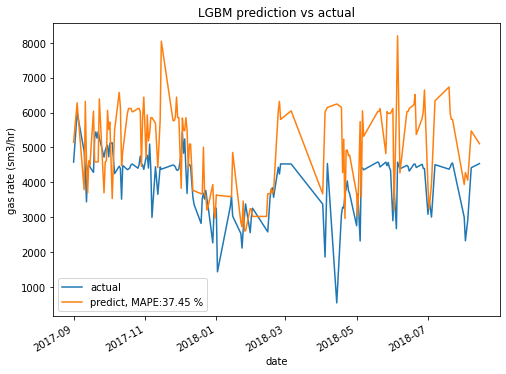

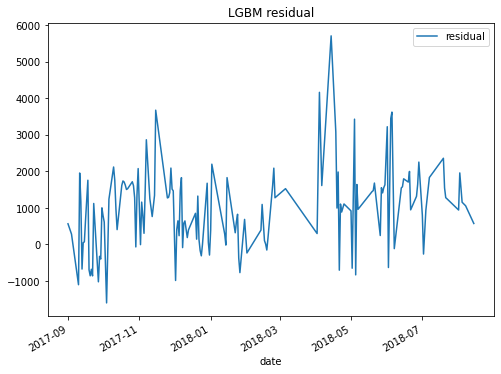

In [19]:
plot_prediction(df_eval)

In [20]:
importances = pd.DataFrame([features, model.feature_importance('gain')], index=['feature', 'importance']).T
importances.sort_values('importance', ascending=False)

,feature,importance
2,whp,1152.498493
3,year,430.068951
0,choke,160.465712
6,rate_shift_1d,156.920029
10,rate_shift_5d,47.903614
8,rate_shift_3d,44.152707
13,rate_shift_8d,35.597774
12,rate_shift_7d,34.658761
7,rate_shift_2d,23.833656
9,rate_shift_4d,22.493965


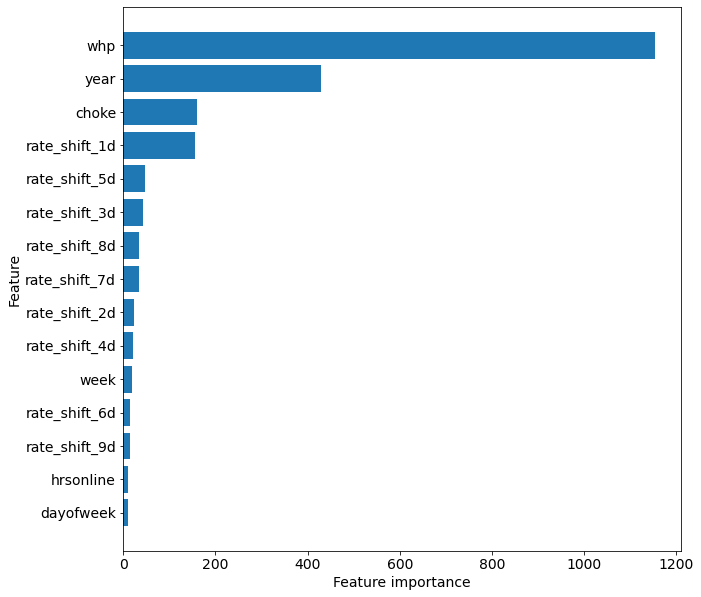

In [21]:
plot_feature_importance(importances)

Jack Bera: 	 Jarque_beraResult(statistic=2557.648513388884, pvalue=0.0)


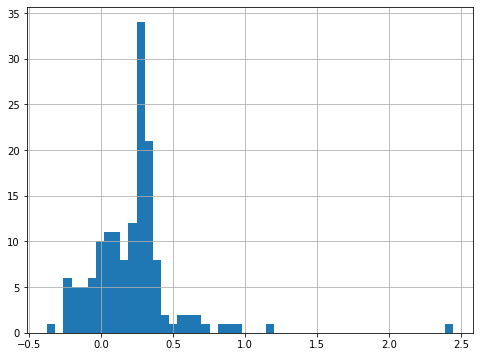

In [22]:
diff_arr = df_eval['pred'] - df_eval['gasrate']

diff_arr.hist(bins=50)

jarque_bera_test = stats.jarque_bera(diff_arr)
print('Jack Bera:', '\t', jarque_bera_test)

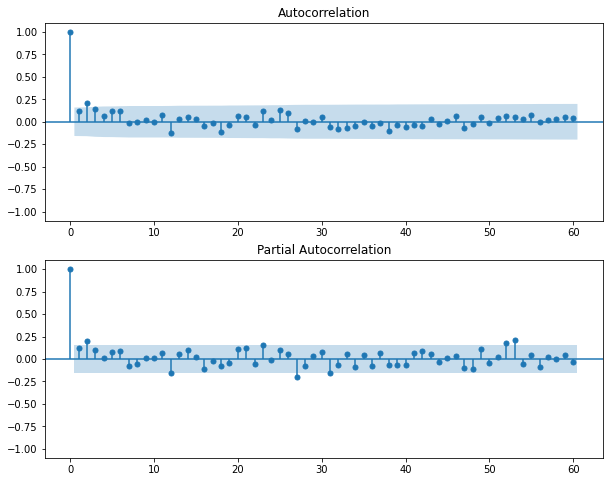

1 2.1108535298342033 0.1462577213243207
2 9.018812851727894 0.011004990515232203
3 12.013009292590862 0.007338728765540113
4 12.772914724411997 0.012440361596660166
5 15.245148412457834 0.009364640668873313
6 17.666013282135836 0.007123366128483495
7 17.685015680246746 0.013474926222564031
8 17.68564850394566 0.023710735137654714
9 17.724708833743062 0.03850511182622254
10 17.725868360601584 0.05976770619877687


/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [23]:
correlation_plot(diff_arr)

results = acorr_ljungbox(diff_arr, lags=10)
lag = 1
for lb, p in zip(results[0], results[1]):
    print(lag, lb, p)
    lag += 1

---ctt---
(-7.087303495420244, 5.049063056875948e-08, 1, 151, {'1%': -4.449541009683263, '5%': -3.872082734430435, '10%': -3.577746361147748}, 61.39413721780727)
---ct---
(-7.072040729822884, 9.702634027215265e-09, 1, 151, {'1%': -4.020010057177695, '5%': -3.4399749739075576, '10%': -3.144351820618417}, 59.41061797213939)
---c---
(-6.625136450323595, 5.90220565470967e-09, 1, 151, {'1%': -3.4744158894942156, '5%': -2.880878382771059, '10%': -2.577081275821236}, 59.69049075853235)
---nc---
(-1.8945776721475667, 0.05546059274003867, 5, 147, {'1%': -2.5811173705400527, '5%': -1.942973103736381, '10%': -1.6151308082642561}, 73.93555311079677)


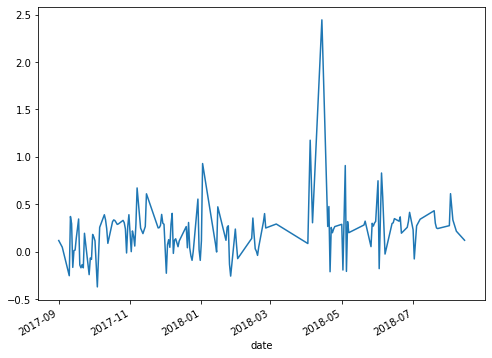

In [24]:
y = diff_arr
y.plot()
regs = ['ctt', 'ct', 'c', 'nc'] # 2次のトレンド＋定数項、1次のトレンド＋定数項, トレンドなし＋定数項、トレンド・定数項なし
for r in regs:
    print(f'---{r}---')
    print(sm.tsa.stattools.adfuller(y, regression=r))